<a href="https://colab.research.google.com/github/djb91/Kaggle/blob/main/spaceshipTitanic_EDA_articleUpdate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Starting Guide to Spaceship Titanic EDA and Random Forest Model with Evaluation

## Notebook Description

This notebook provides:
* in-depth, feature-by-feature analysis of the Spaceship Titanic data;
* data cleaning, preprocessing, and feature engineering;
* training a Random Forest model;
* evaluating model outputs.


Credit to numerous other notebooks that provided inspiration and ideas incorporated here:
* [Spaceship Titanic: A Complete Guide](https://www.kaggle.com/code/samuelcortinhas/spaceship-titanic-a-complete-guide)
* [Spaceship Titanic EDA, XGBoost 80%+](https://www.kaggle.com/code/eisgandar/spaceship-titanic-eda-xgboost-80)


**Please provide feedback in the comments which will help me continue to improve notebooks as I publish them!**

## Import Libraries

In [ ]:
# data analysis 
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 

# data visualization 
import matplotlib.pyplot as plt  
import seaborn as sns

# general utilities 
# !pip install kaggle
import os

# sklearn tools and models
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report



## Custom Functions

*Functions written for use as part of the analysis of this data.*

In [ ]:
def missing_pct(data_lst, col):
  '''Calculate the percentage of missing values from a feature in
      both the train and test dataframes

  Args:
    data_lst: a list containing train and test dataframes, in that order 
    col: the specific feature (column) to calculate the missing values
  
  Returns: Text containing the rounded percentage of missing 
          features in the train and test data 
  '''

  print(f'Percentage of {col} Missing Values in Training Data:', round(data_lst[0][col].isna().sum() / data_lst[0].shape[0], 3))
  print(f'Percentage of {col} Missing Values in Test Data:', round(data_lst[1][col].isna().sum() / data_lst[1].shape[0], 3))


In [ ]:
def transported_NAs(df, col):
  '''Given a feature, determine how many passengers 
      with NAs were transported
      
  Args:
    df: training df that contains 'Transported' column
    col: specific column to test for missing data 
  
  Returns: percentage of passengers with NAs in the col who were transported
  '''
  print(f'Analyzing {col}:')
  print(
      round(
        df[df[col].isna()][['Transported']]
        .mean()
        .rename({'Transported':'Percentage of NAs Transported:'}), 3
  ))

In [ ]:
def plot_categorical_barh(df: pd.DataFrame, 
                     col: str, 
                     title: str,
                     figsize: tuple = (10,5),
                     color: list = ['b']) -> None:
  '''Generate hbar plot of one categorical dataframe feature

  Args:
    df: pandas DataFrame containing the data 
    col: categorical column to produce the barh chart 
    title: title of the barh chart 
    figsize: tuple containing chart dimensions; defaults to (10,5)
    color: chart color; defaults to blue 

  Returns:
    no object returned; plots the barh chart 
  '''
  (
    df[col]
    .value_counts(normalize=True)
    .sort_values(ascending=True)
    .plot(kind='barh',
          figsize=figsize,
          title=title,
          color=color)
  )

  plt.show()

In [ ]:
def plot_transported_pct(df: pd.DataFrame, 
                         col: str, 
                         title: str,
                         figsize: tuple = (10,5),
                         color: str = 'r') -> None:
  '''Generate a horizontal bar chart of transported pct for a category

  Args:
    df: pandas dataframe containing the data 
    col: column to analyze transported percentage 

  Returns:
    None; plots a chart of the pct of passengers transported
  '''
  (
    df[[col, 'Transported']]
    .groupby(col)
    .agg('mean')
    .sort_values('Transported')
    .plot(kind='barh',
          figsize=figsize,
          color = color,
          title=title)
  )
  plt.show()

## Import Data 

In [ ]:
train_df = pd.read_csv("../input/spaceship-titanic/train.csv")
test_df = pd.read_csv("../input/spaceship-titanic/test.csv")

print('train dataframe dimensions:', train_df.shape)
print('test dataframe dimensions:', test_df.shape)

train dataframe dimensions: (8693, 14)
test dataframe dimensions: (4277, 13)


In [ ]:
# combine into a single list
full_data = [train_df, test_df]
len(full_data)

2

##  Exploratory Data Analysis

### High-Level Data Overview

**Train Data**

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [ ]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


**Test Data**

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [ ]:
test_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


**Analysis**
* The training data is approximately double the size of the test data, providing an overall breakdown of routhly 2/3 training and 1/3 test.
* With such a large test data set, we may need to check if there are any unknown features (i.e., categorical dummy variables) and make sure they are incorporated into the test data as features to prevent modeling errors. 
* Features in both the train and test data appear to be missing a small percentage of values; no features seem to have substantial missing data.

### Descriptive Statistics

**Descriptive Statistics -- Quantitative Features**

In [ ]:
train_df.describe().round().T

,count,mean,std,min,25%,50%,75%,max
Age,8514.0,29.0,14.0,0.0,19.0,27.0,38.0,79.0
RoomService,8512.0,225.0,667.0,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,458.0,1611.0,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,174.0,605.0,0.0,0.0,0.0,27.0,23492.0
Spa,8510.0,311.0,1137.0,0.0,0.0,0.0,59.0,22408.0
VRDeck,8505.0,305.0,1146.0,0.0,0.0,0.0,46.0,24133.0


In [ ]:
test_df.describe().round().T

,count,mean,std,min,25%,50%,75%,max
Age,4186.0,29.0,14.0,0.0,19.0,26.0,37.0,79.0
RoomService,4195.0,219.0,607.0,0.0,0.0,0.0,53.0,11567.0
FoodCourt,4171.0,439.0,1528.0,0.0,0.0,0.0,78.0,25273.0
ShoppingMall,4179.0,177.0,561.0,0.0,0.0,0.0,33.0,8292.0
Spa,4176.0,303.0,1117.0,0.0,0.0,0.0,50.0,19844.0
VRDeck,4197.0,311.0,1247.0,0.0,0.0,0.0,36.0,22272.0


*Analysis of Training Data:*
* Age: The youngest passenger is 0 years old, which could be an error or represent a newborn. The oldest is 79 with the mean being 29 and the median being 27 (indicating a slight skew). The train and test data sets are similar in this regard.
* Spend Categories: Based on the median values being zero, most passengers don't seem to spend in the various locations. The data also appear to be skewed due to passengers who spend relatively large amounts in each of the categories.
  * The test data spend amounts are generally lower than the train data across the board.
  * In the test data the max ShoppingMall amount is only 8,292, which is far lower than the max of 23,492 in the train data. 

**Descriptive Statistics -- Categorical Data**

In [ ]:
train_df.describe(include='object').round().T

,count,unique,top,freq
PassengerId,8693,8693,0001_01,1
HomePlanet,8492,3,Earth,4602
CryoSleep,8476,2,False,5439
Cabin,8494,6560,G/734/S,8
Destination,8511,3,TRAPPIST-1e,5915
VIP,8490,2,False,8291
Name,8493,8473,Gollux Reedall,2


In [ ]:
test_df.describe(include='object').round().T

,count,unique,top,freq
PassengerId,4277,4277,0013_01,1
HomePlanet,4190,3,Earth,2263
CryoSleep,4184,2,False,2640
Cabin,4177,3265,G/160/P,8
Destination,4185,3,TRAPPIST-1e,2956
VIP,4184,2,False,4110
Name,4183,4176,Cints Erle,2


*Analysis:*
* Train and Test data appears to be generally similar:
  * HomePlanet: Three unique values with Earth as the most common, comprising slightly more than 50%.
  * CryoSleep: Boolean with False comprising almost 65%.
  * Destination: Three unique values with TRAPPIST-1e comprising 70%.
  * VIP: Boolean with False comprising 99%. 

PassengerId, Cabin, and Name all comprise mostly unique values, although there appear to be passengers with duplicate names which we will need to investigate.

### Overview of Missing Values

Percentage of missing data in train and test data sets:



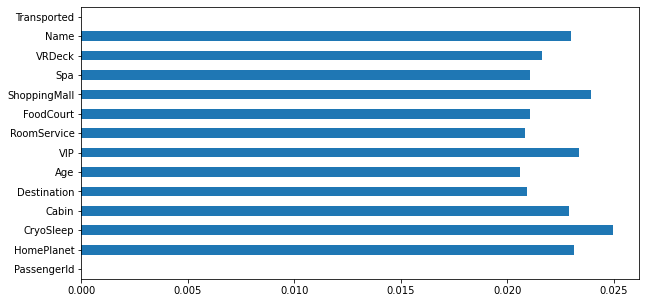

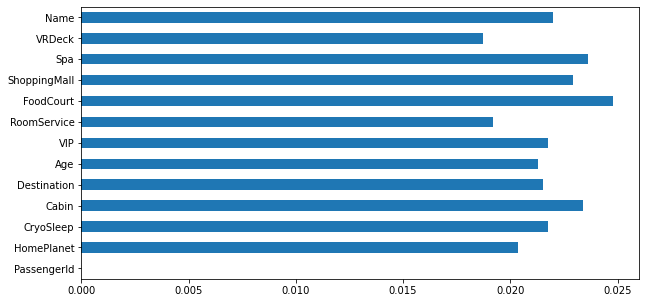

In [ ]:
print('Percentage of missing data in train and test data sets:\n')
for df in full_data:
  (
      df.isna().mean()
      .plot(kind='barh',
            figsize=(10,5))
  )
  plt.show()
  print('')

**Analysis**
* PassengerId contains zero missing values in the train and test data sets 
* In the train data set, Transported also contains zero missing values 
* All other features in both the train and test data sets contain roughly 0.02 to 0.025 percent missing values
* For the train data the 0.02 correlates to approx. 180-200 values per feature 

## Summary of Data Preprocessing

### Summary Steps
* **PassengerId:** parse into Passenger_Group, Passenger_Num, and Group_Size
* **HomePlanet:** impute most frequent and convert to categorical
* **CryoSleep:** impute most frequent; convert to boolean
* **Cabin:** Fill missing values with 'Z/99999/Z' and parse into new Cabin_Deck, Cabin_Num, and Cabin_Side features
* **Destination:** impute most frequent and convert to categorical
* **Age:** Impute median value
* **VIP:** Impute most frequent and convert to boolean
* **RoomService:** Impute median value
* **FoodCourt:** Impute median value
* **ShoppingMall:** Impute median value
* **Spa:** Impute median value
* **VRDeck:** Impute median value
* **Name:** impute 'NoFirstName NoLastName'
* **Transported:** converted to Boolean; train data only



### Preprocess Data

In [ ]:
# convert Transported to boolean; only in train_df 
train_df['Transported'] = train_df['Transported'].astype(bool)

# format bulk of data sets 
for df in full_data:

  # IMPUTE MISSING VALUES 
  df['Name'].fillna('NoFirstName NoSurname', inplace=True)
  df['HomePlanet'].fillna(df['HomePlanet'].value_counts().index[0], inplace=True)
  df['CryoSleep'].fillna(df['CryoSleep'].value_counts().index[0], inplace=True)
  df['Cabin'].fillna('Z/99999/Z', inplace=True)
  df['Destination'].fillna(df['Destination'].value_counts().index[0], inplace=True)
  df['VIP'].fillna(df['VIP'].value_counts().index[0], inplace=True)
  df['Age'].fillna(df['Age'].median(), inplace=True)
  df['RoomService'].fillna(df['RoomService'].median(), inplace=True)
  df['FoodCourt'].fillna(df['FoodCourt'].median(), inplace=True)
  df['ShoppingMall'].fillna(df['ShoppingMall'].median(), inplace=True)
  df['Spa'].fillna(df['Spa'].median(), inplace=True)
  df['VRDeck'].fillna(df['VRDeck'].median(), inplace=True)

  # CREATE FEATURES 
  df['Passenger_Group'] = df['PassengerId'].apply(lambda x: x.split('_')[0]).astype(str)
  df['Passenger_Num'] = df['PassengerId'].apply(lambda x: x.split('_')[1]).astype(str)
  df['Cabin_Deck'] = df['Cabin'].apply(lambda x: x.split('/')[0]).astype(str)
  df['Cabin_Num'] = df['Cabin'].apply(lambda x: x.split('/')[1]).astype(str)
  df['Cabin_Side'] = df['Cabin'].apply(lambda x: x.split('/')[2]).astype(str) 

  # FORMAT DATA TYPES 
  df['HomePlanet'] = df['HomePlanet'].astype('category')
  df['CryoSleep'] = df['CryoSleep'].astype('bool')
  df['Cabin_Deck'] = df['Cabin_Deck'].astype('category')
  df['Cabin_Side'] = df['Cabin_Side'].astype('category')
  df['Destination'] = df['Destination'].astype('category')


# use completed features to generate new features
for df in full_data:
  df['Group_Size'] = df['Passenger_Group'].map(lambda x: pd.concat([train_df['Passenger_Group'], 
                                                                    test_df['Passenger_Group']]).value_counts()[x])




In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   PassengerId      8693 non-null   object  
 1   HomePlanet       8693 non-null   category
 2   CryoSleep        8693 non-null   bool    
 3   Cabin            8693 non-null   object  
 4   Destination      8693 non-null   category
 5   Age              8693 non-null   float64 
 6   VIP              8693 non-null   bool    
 7   RoomService      8693 non-null   float64 
 8   FoodCourt        8693 non-null   float64 
 9   ShoppingMall     8693 non-null   float64 
 10  Spa              8693 non-null   float64 
 11  VRDeck           8693 non-null   float64 
 12  Name             8693 non-null   object  
 13  Transported      8693 non-null   bool    
 14  Passenger_Group  8693 non-null   object  
 15  Passenger_Num    8693 non-null   object  
 16  Cabin_Deck       8693 non-null   category


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   PassengerId      4277 non-null   object  
 1   HomePlanet       4277 non-null   category
 2   CryoSleep        4277 non-null   bool    
 3   Cabin            4277 non-null   object  
 4   Destination      4277 non-null   category
 5   Age              4277 non-null   float64 
 6   VIP              4277 non-null   bool    
 7   RoomService      4277 non-null   float64 
 8   FoodCourt        4277 non-null   float64 
 9   ShoppingMall     4277 non-null   float64 
 10  Spa              4277 non-null   float64 
 11  VRDeck           4277 non-null   float64 
 12  Name             4277 non-null   object  
 13  Passenger_Group  4277 non-null   object  
 14  Passenger_Num    4277 non-null   object  
 15  Cabin_Deck       4277 non-null   category
 16  Cabin_Num        4277 non-null   object  


## Categorical Feature Analysis

*Note: This analysis will generally focus on the training dataset*

### Transported
*Whether the passenger was transported to another dimension. This is the target, the column we are trying to predict.*

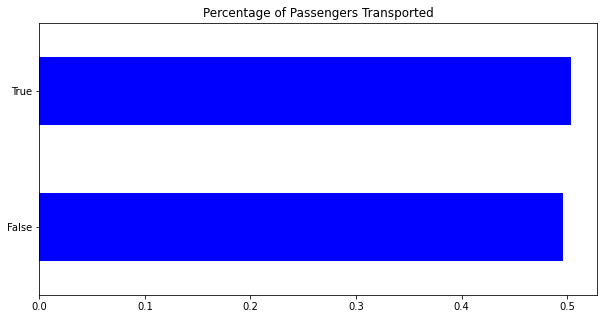

In [ ]:
plot_categorical_barh(df=train_df, col='Transported', title='Percentage of Passengers Transported')

**Analysis of Transported:**
* Approximately half of the passengers were transported, with slightly more being transported than not. 
* At this point we don't have a way to confirm whether the test data has the same distribution.

### PassengerId
*A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.*

We used PassengerId to create additional features: 
* *Passenger_Group* for each group 
* *Passenger_Num* for each group member 
* *Group_Size* to count the number of members in each group

### Passenger Group Size
Number of members traveling as part of a specific passenger group. This feature was created from PassengerId.

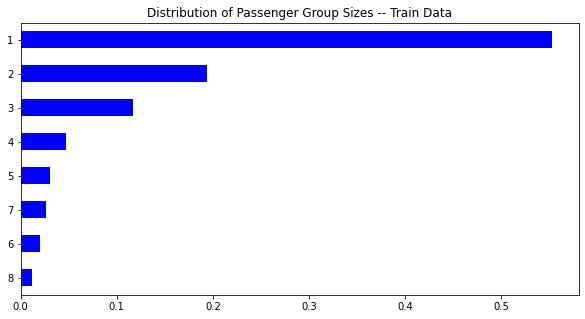

In [ ]:
plot_categorical_barh(df=train_df, col='Group_Size', 
                 title='Distribution of Passenger Group Sizes -- Train Data')

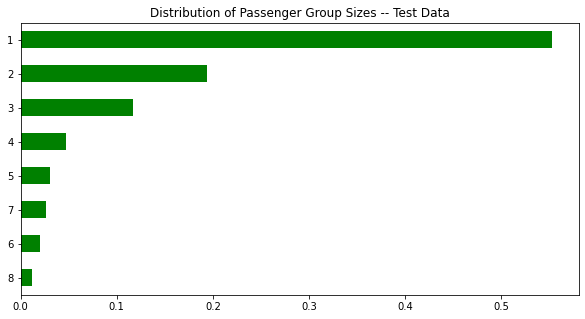

In [ ]:
plot_categorical_barh(df=train_df, col='Group_Size', 
                 title='Distribution of Passenger Group Sizes -- Test Data',
                 color=['g'])

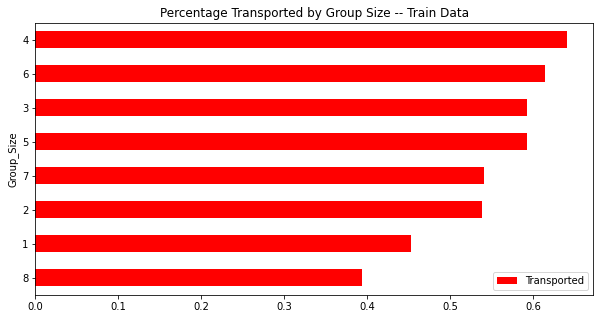

In [ ]:
plot_transported_pct(df=train_df, 
                     col='Group_Size',
                     title='Percentage Transported by Group Size -- Train Data')

**Analysis of Group Size**
* Among all passengers, approximately half were transported to another dimension. 
* When analyzed by group size, it appears that passengers traveling in groups with two to seven members were between 4% and 14% more likely to be transported.
* Passengers traveling alone were 5% less likely to be transported than the average.

### Passenger Name
*The first and last names of the passenger.*

**Passengers with Duplicate Names**

In [ ]:
duplicate_names = train_df['Name'].value_counts()[train_df['Name'].value_counts() == 2].index
print('Number of passengers with same name:', len(duplicate_names))

Number of passengers with same name: 20


In [ ]:
train_df['Name'].value_counts()[train_df['Name'].value_counts() == 2]

Sus Coolez            2
Elaney Webstephrey    2
Dia Cartez            2
Grake Porki           2
Apix Wala             2
Sharie Gallenry       2
Cuses Pread           2
Alraium Disivering    2
Carry Contrevins      2
Keitha Josey          2
Gollux Reedall        2
Loree Wolfernan       2
Gwendy Sykess         2
Asch Stradick         2
Troya Schwardson      2
Glena Hahnstonsen     2
Anton Woody           2
Juane Popelazquez     2
Ankalik Nateansive    2
Glenna Valezaley      2
Name: Name, dtype: int64

In [ ]:
# dataframe of just passengers with duplicate names
duplicate_names_df = train_df[train_df['Name'].isin(list(duplicate_names))].copy()
duplicate_names_df.shape

(40, 20)

In [ ]:
duplicate_names_df.sort_values(by='Name', ascending=True).head(6)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Passenger_Group,Passenger_Num,Cabin_Deck,Cabin_Num,Cabin_Side,Group_Size
7270,7775_01,Europa,False,C/253/P,55 Cancri e,28.0,False,7.0,489.0,0.0,4.0,6027.0,Alraium Disivering,False,7775,01,C,253,P,1
6296,6665_01,Europa,True,B/222/P,55 Cancri e,17.0,False,0.0,0.0,0.0,0.0,0.0,Alraium Disivering,True,6665,01,B,222,P,4
476,0512_02,Europa,True,D/18/S,TRAPPIST-1e,55.0,False,0.0,0.0,0.0,0.0,0.0,Ankalik Nateansive,True,0512,02,D,18,S,2
2930,3176_01,Europa,False,E/196/P,TRAPPIST-1e,77.0,False,0.0,9032.0,0.0,128.0,1464.0,Ankalik Nateansive,True,3176,01,E,196,P,1
8488,9071_01,Earth,False,F/1855/P,55 Cancri e,22.0,False,0.0,0.0,1072.0,46.0,3.0,Anton Woody,False,9071,01,F,1855,P,1
2991,3236_03,Earth,False,E/200/P,TRAPPIST-1e,18.0,False,0.0,30.0,0.0,756.0,5.0,Anton Woody,False,3236,03,E,200,P,3


In [ ]:
# likelihood of being transported with duplicate name 
duplicate_names_df['Transported'].value_counts(normalize=True)

False    0.575
True     0.425
Name: Transported, dtype: float64

In [ ]:
# transported_NAs(df=train_df, col='Name')

**Analysis of Passenger Names**
* We filled the missing values with 'NoFirstName NoSurname'
* There are 20 passengers with the same name, but overall these are different entries.
* Passengers with duplicate names appear to have a slightly lower likelihood of being transported, but it is a small data set.

### Home Planet
*Definition: The planet the passenger departed from, typically their planet of permanent residence.*

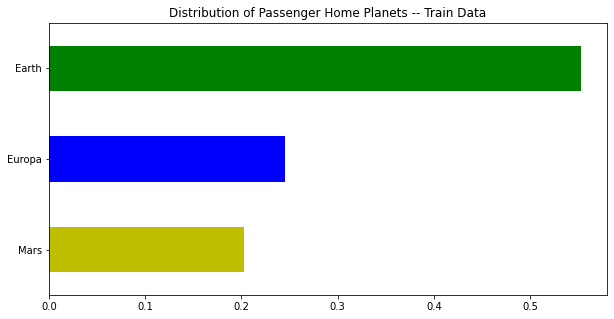

In [ ]:
plot_categorical_barh(df=train_df, 
                      col='HomePlanet',
                      color=['y', 'b', 'g'],
                      title='Distribution of Passenger Home Planets -- Train Data')

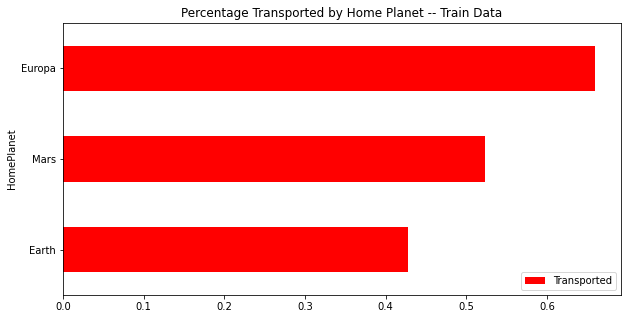

In [ ]:
plot_transported_pct(df=train_df,
                     col='HomePlanet',
                     title='Percentage Transported by Home Planet -- Train Data')

**Analysis of HomePlanet**
* A majority of passengers are from Earth.
* However, passengers from Earth appear to be almost 10% less likely to be transported, while passengers from Europa are 10%+ more likely to be transported. 

### CryoSleep
*Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.*

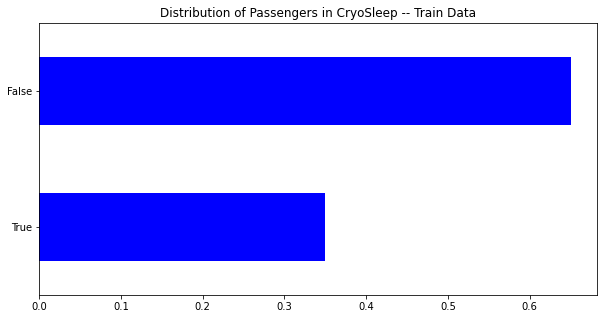

In [ ]:
plot_categorical_barh(df=train_df, 
                      col='CryoSleep',
                      title='Distribution of Passengers in CryoSleep -- Train Data')

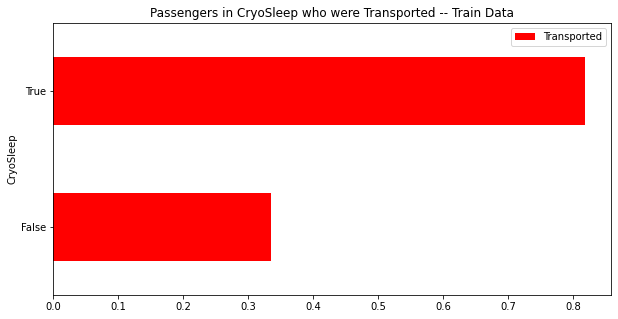

In [ ]:
plot_transported_pct(df=train_df,
                     col='CryoSleep',
                     title='Passengers in CryoSleep who were Transported -- Train Data')

**Analysis of CryoSleep**
* Approximately 35% of passengers are in CryoSleep. 
* Passengers who are in cryo sleep appear to have an almost 80 percent chance of being transported, compared to approximately 35 percent for those who are not in cryo sleep. 

### Cabin
*The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard. Parsed cabin into Cabin_Deck, Cabin_Num, and Cabin_Side features.*

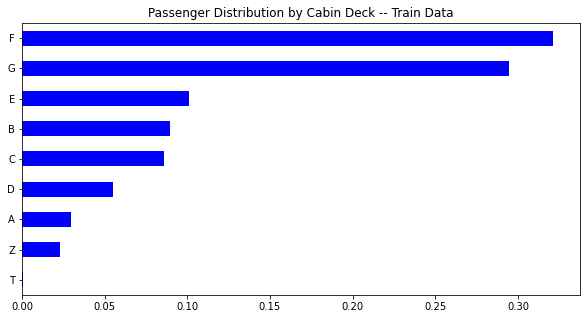

In [ ]:
plot_categorical_barh(df=train_df,
                      col='Cabin_Deck',
                      title='Passenger Distribution by Cabin Deck -- Train Data')

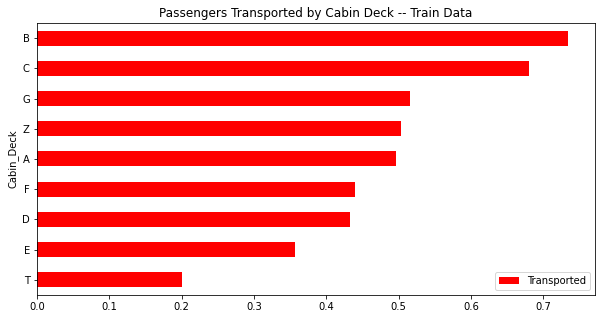

In [ ]:
plot_transported_pct(df=train_df,
                     col='Cabin_Deck',
                     title='Passengers Transported by Cabin Deck -- Train Data')

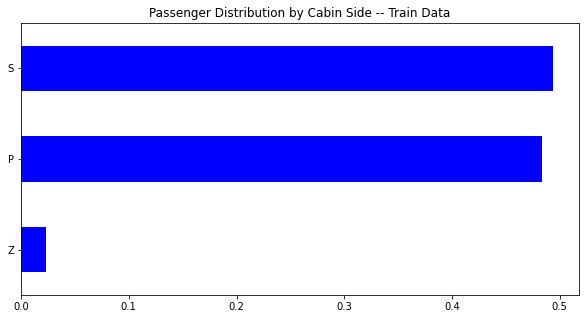

In [ ]:
plot_categorical_barh(df=train_df,
                      col='Cabin_Side',
                      title='Passenger Distribution by Cabin Side -- Train Data')

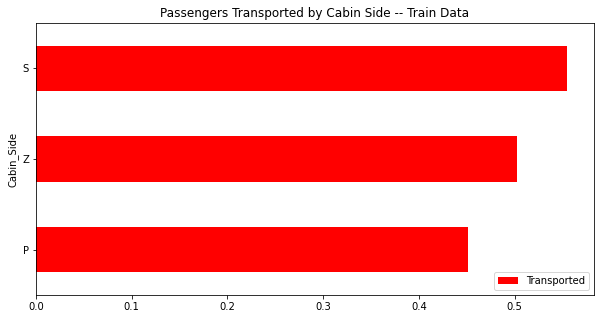

In [ ]:
plot_transported_pct(df=train_df,
                     col='Cabin_Side',
                     title='Passengers Transported by Cabin Side -- Train Data')

**Analysis of Cabin and Related Features**
* Cabin Decks G and F contain the most passengers, but those passengers on Decks B and C are the most likely to be transported.
* Passengers are generally evenly distributed between the Port and Starboard sides with passengers on the Starboard side having a slightly higher chance of being transported.

### Destination
*The planet the passenger will be debarking to.*


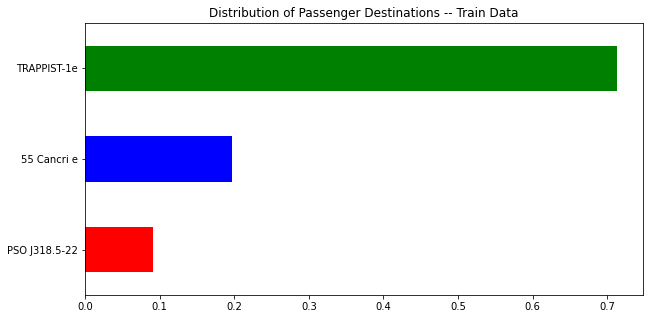

In [ ]:
plot_categorical_barh(df=df,
                      col='Destination',
                      color=['r', 'b', 'g'],
                      title='Distribution of Passenger Destinations -- Train Data')

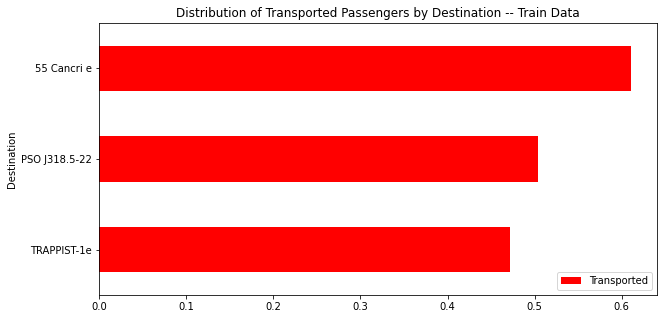

In [ ]:
plot_transported_pct(df=train_df,
                     col='Destination',
                     title='Distribution of Transported Passengers by Destination -- Train Data')

**Analysis of Destination:**
* TRAPPIST-1e is the most common destination and guests traveling there have roughly the same chance of being transported as the full passenger population.
* Passengers traveling to the destination '55 Cancri e' appaer to have a slightly elevated probability of being transported.

### VIP Status
*Whether the passenger has paid for special VIP service during the voyage.*

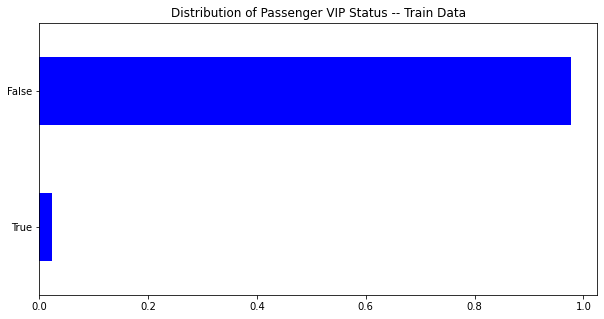

In [ ]:
plot_categorical_barh(df=train_df,
                      col='VIP',
                      title='Distribution of Passenger VIP Status -- Train Data')

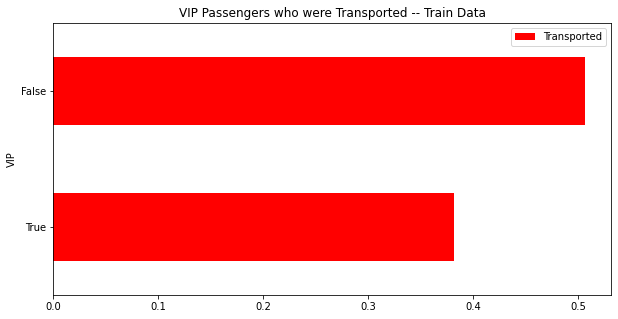

In [ ]:
plot_transported_pct(df=train_df,
                     col='VIP',
                     title='VIP Passengers who were Transported -- Train Data')

**Analysis of VIP Status**
* Although relatively few passengers paid for VIP status, those tho did appear to have a slightly lower rate of transportation than the overall passenger population.

## Quantitative Feature Analysis

### Age
*The age of the passenger.*

In [ ]:
round(train_df['Age'].describe(), 2)

count    8693.00
mean       28.79
std        14.34
min         0.00
25%        20.00
50%        27.00
75%        37.00
max        79.00
Name: Age, dtype: float64

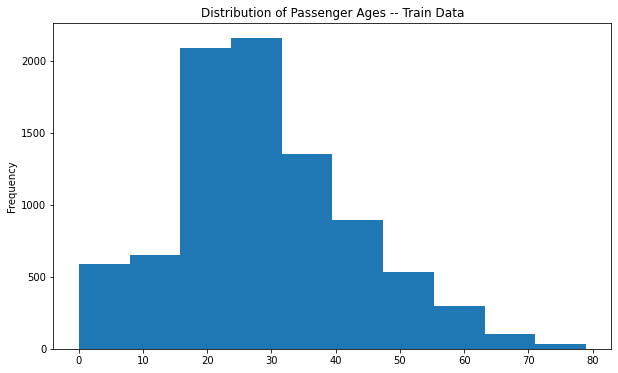

In [ ]:
train_df['Age'].plot(kind='hist',
                     title='Distribution of Passenger Ages -- Train Data',
                     figsize = (10, 6))
plt.show()

**Analysis of Passenger Age**
* The mean and median age are roughly 27 and 28 years old, indicating that the data is only lightly skewed.
* The age range is 0 to 79, with the fewest passengers at the upper end of the range.

### Room Service
*Amount passenger billed for room service.*


In [ ]:
round(train_df['RoomService'].describe(), 2)

count     8693.00
mean       220.01
std        660.52
min          0.00
25%          0.00
50%          0.00
75%         41.00
max      14327.00
Name: RoomService, dtype: float64

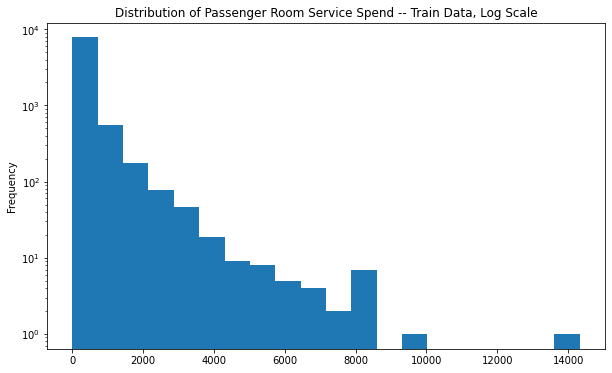

In [ ]:
train_df['RoomService'].plot(kind='hist',
                             log=True,
                             bins=20,
                             title='Distribution of Passenger Room Service Spend -- Train Data, Log Scale',
                             figsize=(10, 6))
plt.show()

In [ ]:
print('Percentage of passengers spending any money on room service:', 
  round(train_df[train_df['RoomService'] > 0].shape[0] / train_df.shape[0], 2))

Percentage of passengers spending any money on room service: 0.34


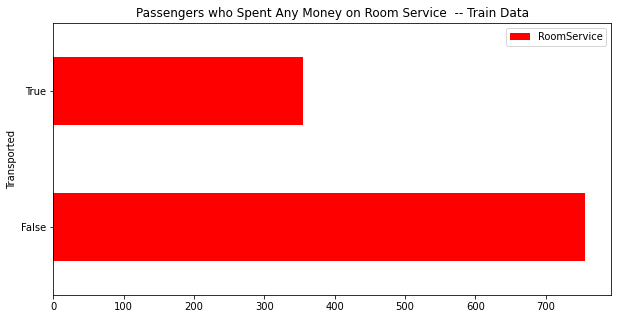

In [ ]:
(
    train_df[train_df['RoomService'] > 0][['RoomService', 'Transported']]
    .groupby('Transported')
    .agg('mean')
    .plot(kind='barh',
        figsize=(10,5),
        color=['r'],
        title='Passengers who Spent Any Money on Room Service  -- Train Data')
)
plt.show()

**Analysis of Room Service Spend**
* Only 34% of passengers spent money on Room Service.
* Of those who did, the data is heavily skewed by a few passengers who spent large amounts.
* Passengers who spent any money on room service appear to have a lower likelihood of being transported. 

### Food Court
*Amount passenger spent at the food court*

In [ ]:
round(train_df['FoodCourt'].describe(), 2)

count     8693.00
mean       448.43
std       1595.79
min          0.00
25%          0.00
50%          0.00
75%         61.00
max      29813.00
Name: FoodCourt, dtype: float64

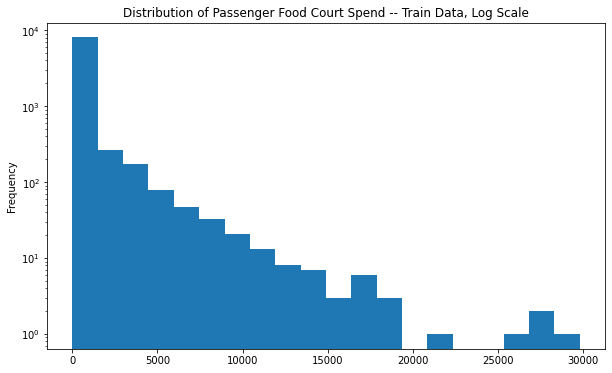

In [ ]:
train_df['FoodCourt'].plot(kind='hist',
                           log=True,
                           title='Distribution of Passenger Food Court Spend -- Train Data, Log Scale',
                           bins=20,
                           figsize=(10,6))
plt.show()

In [ ]:
print('Percentage of passengers spending any money at the Food Court:', 
  round(train_df[train_df['FoodCourt'] > 0].shape[0] / train_df.shape[0], 2))

Percentage of passengers spending any money at the Food Court: 0.35


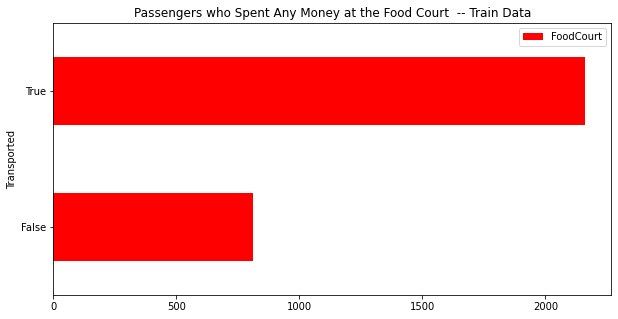

In [ ]:
(
    train_df[train_df['FoodCourt'] > 0][['FoodCourt', 'Transported']]
    .groupby('Transported')
    .agg('mean')
    .plot(kind='barh',
        figsize=(10,5),
        color=['r'],
        title='Passengers who Spent Any Money at the Food Court  -- Train Data')
)
plt.show()

**Analysis of Food Court Spend**
* Similar to other categories, roughly one-third of passengers spent money in the food court.
* The spend was heavily skewed by a few passengers spending large amounts.
* Customers who spent money in the food court appear to be disproportionally transported compared to the overall passenger population. 

### Shopping Mall
*Amount passenger spent at shopping mall.*

In [ ]:
round(train_df['ShoppingMall'].describe(), 2)

count     8693.00
mean       169.57
std        598.01
min          0.00
25%          0.00
50%          0.00
75%         22.00
max      23492.00
Name: ShoppingMall, dtype: float64

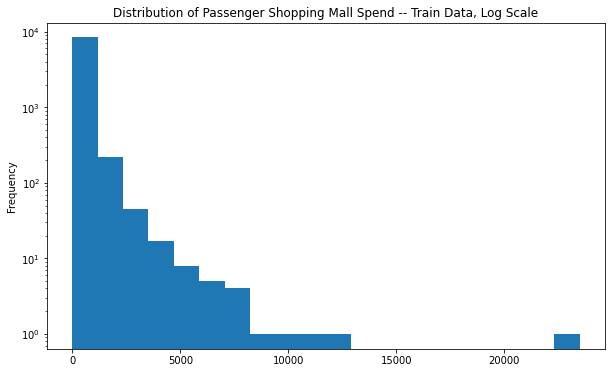

In [ ]:
train_df['ShoppingMall'].plot(kind='hist',
                              log=True,
                              bins=20,
                              title='Distribution of Passenger Shopping Mall Spend -- Train Data, Log Scale',
                              figsize=(10,6))
plt.show()

In [ ]:
print('Percentage of passengers spending any money at the shopping mall:', 
  round(train_df[train_df['ShoppingMall'] > 0].shape[0] / train_df.shape[0], 2))

Percentage of passengers spending any money at the shopping mall: 0.33


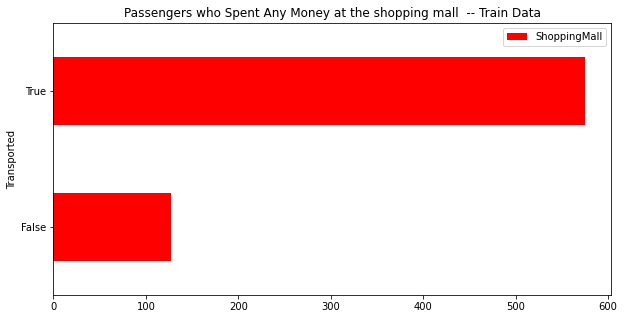

In [ ]:
(
    train_df[train_df['ShoppingMall'] > 0][['ShoppingMall', 'Transported']]
    .groupby('Transported')
    .agg('median')
    .plot(kind='barh',
        figsize=(10,5),
        color=['r', 'b'],
        title='Passengers who Spent Any Money at the shopping mall  -- Train Data')
)
plt.show()

**Analysis of Shopping Mall Spend**
* Similar to other categories, roughly one-third of passengers spent money in the Shopping Mall.
* This spend is heavily skewed by a small number of passengers who spent large amounts.
* Passengers who spent money in the Shopping Mall appear to be much more likely to be transported.

### Spa
*Amount passenger spent at the spa*

In [ ]:
round(train_df['Spa'].describe(), 2)

count     8693.00
mean       304.59
std       1125.56
min          0.00
25%          0.00
50%          0.00
75%         53.00
max      22408.00
Name: Spa, dtype: float64

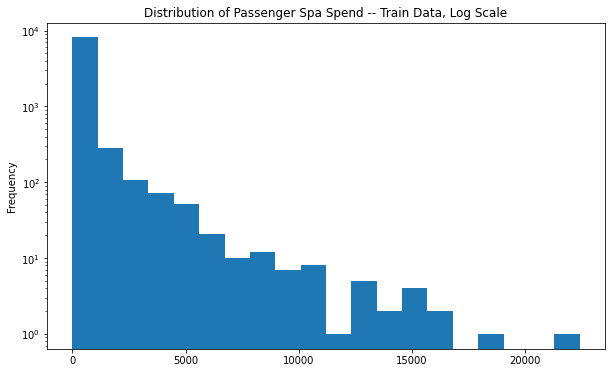

In [ ]:
train_df['Spa'].plot(kind='hist',
                     log=True,
                     bins=20,
                     title='Distribution of Passenger Spa Spend -- Train Data, Log Scale',
                     figsize=(10,6))
plt.show()

In [ ]:
print('Percentage of passengers spending any money at the spa:', 
  round(train_df[train_df['Spa'] > 0].shape[0] / train_df.shape[0], 2))

Percentage of passengers spending any money at the spa: 0.37


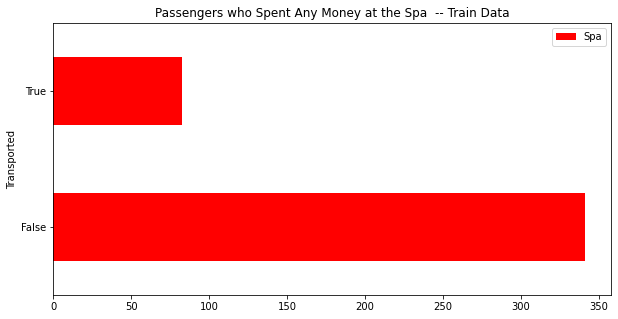

In [ ]:
(
    train_df[train_df['Spa'] > 0][['Spa', 'Transported']]
    .groupby('Transported')
    .agg('median')
    .plot(kind='barh',
        figsize=(10,5),
        color=['r', 'b'],
        title='Passengers who Spent Any Money at the Spa  -- Train Data')
)
plt.show()

**Analysis of Customer Spa Spend**
* Slightly more than one-third of passengers spent money at the spa.
* As with the other spend categories, Spa spend is heavily skewed by a few high-spending passengers.
* Passengers who spent money at the Spa appear much less likely to be transported than the overall population. 

### VR Deck

In [ ]:
round(train_df['VRDeck'].describe(), 2)

count     8693.00
mean       298.26
std       1134.13
min          0.00
25%          0.00
50%          0.00
75%         40.00
max      24133.00
Name: VRDeck, dtype: float64

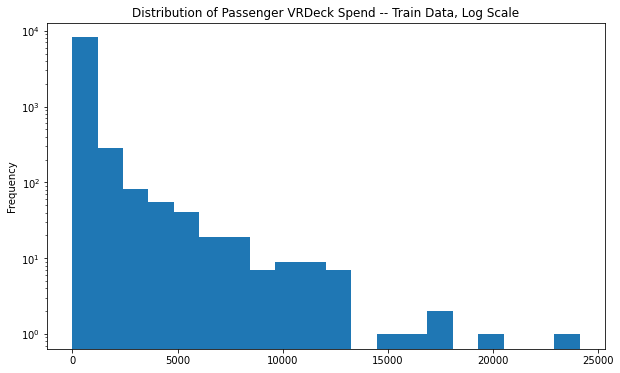

In [ ]:
train_df['VRDeck'].plot(kind='hist',
                     log=True,
                     bins=20,
                     title='Distribution of Passenger VRDeck Spend -- Train Data, Log Scale',
                     figsize=(10,6))
plt.show()

In [ ]:
print('Percentage of passengers spending any money at the VR Deck:', 
  round(train_df[train_df['VRDeck'] > 0].shape[0] / train_df.shape[0], 2))

Percentage of passengers spending any money at the VR Deck: 0.35


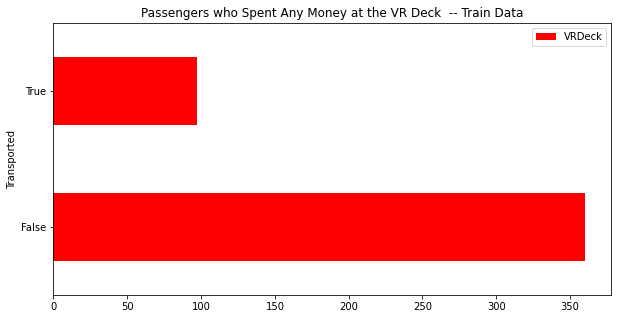

In [ ]:
(
    train_df[train_df['VRDeck'] > 0][['VRDeck', 'Transported']]
    .groupby('Transported')
    .agg('median')
    .plot(kind='barh',
        figsize=(10,5),
        color=['r', 'b'],
        title='Passengers who Spent Any Money at the VR Deck  -- Train Data')
)
plt.show()

**Analysis of Customer VR Deck Spend**
* Slightly more than one-third of passengers spent money at the VR Deck.
* As with the other spend categories, VR Deck spend is heavily skewed by a few high-spending passengers.
* Passengers who spent money at the VR Deck appear much less likely to be transported than the overall population. 

## Finalize Data for ML Models

### One-Hot Encoding

In [ ]:
# create y as the target value 
y = train_df['Transported']
y.shape

(8693,)

In [ ]:
# features to use for the model 
train_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP',
                  'Group_Size', 'Cabin_Deck', 'Cabin_Side',
                  'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

len(train_features)

13

In [ ]:
# generate dummy variables from categoricals 
X = pd.get_dummies(train_df[train_features], drop_first=True)
X.shape


(8693, 23)

In [ ]:
X.head()

,CryoSleep,VIP,Group_Size,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Europa,HomePlanet_Mars,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Cabin_Deck_B,Cabin_Deck_C,Cabin_Deck_D,Cabin_Deck_E,Cabin_Deck_F,Cabin_Deck_G,Cabin_Deck_T,Cabin_Deck_Z,Cabin_Side_S,Cabin_Side_Z
0,False,False,1,39.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1,1,0,0,0,0,0,0,0,0,0
1,False,False,1,24.0,109.0,9.0,25.0,549.0,44.0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
2,False,True,2,58.0,43.0,3576.0,0.0,6715.0,49.0,1,0,0,1,0,0,0,0,0,0,0,0,1,0
3,False,False,2,33.0,0.0,1283.0,371.0,3329.0,193.0,1,0,0,1,0,0,0,0,0,0,0,0,1,0
4,False,False,1,16.0,303.0,70.0,151.0,565.0,2.0,0,0,0,1,0,0,0,0,1,0,0,0,1,0


In [ ]:
X_test = pd.get_dummies(test_df[train_features], drop_first=True)
X_test.shape

(4277, 23)

In [ ]:
# confirm same columns; identify any discrepancies
[col for col in list(X.columns) if col not in list(X_test.columns)]


[]

### Check Feature Correlation

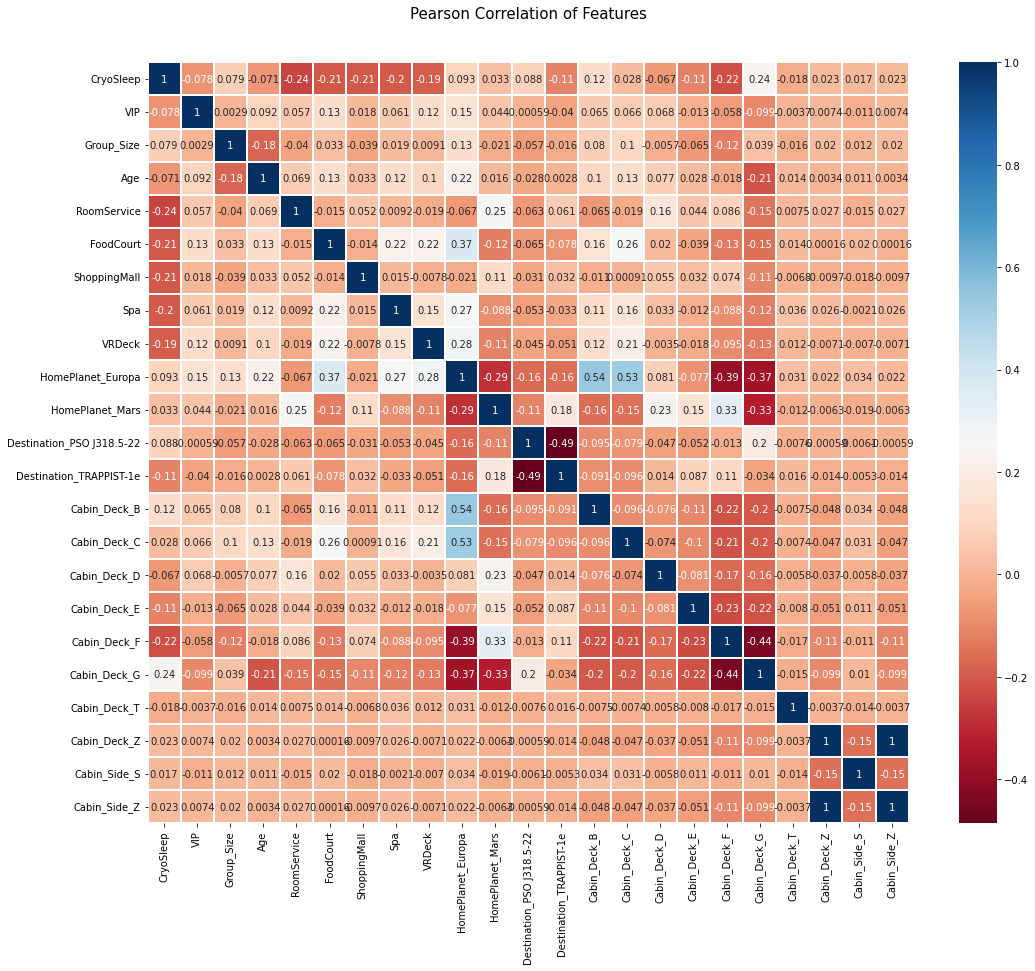

In [ ]:
# correlation map of the fatures 
colormap = plt.cm.RdBu
plt.figure(figsize=(18,14))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(X.astype(float).corr(),
            linewidths=0.1,
            vmax=1.0, 
            square=True, 
            cmap=colormap, 
            linecolor='white', 
            annot=True)

plt.show()

## Train Random Forest Model

### Identify Optimal RF Parameters

**Establish RandomizedSearchCV**

In [ ]:
# rf_model_cv = RandomForestClassifier(oob_score=True, random_state=1, n_jobs=-1)

# param_grid_rf = {'criterion' : ["gini", "entropy"], 
#                  'max_features': ['log2', 'sqrt', None],
#                  'max_depth': [2, 4, 8, 16, 32, 64],
#                  'min_samples_leaf' : [1, 5, 10, 20], 
#                  'min_samples_split' : [2, 4, 10, 14, 18], 
#                  'n_estimators': [100, 200, 300, 400, 500]}

# gs_rf = RandomizedSearchCV(estimator=rf_model_cv, 
#                            param_distributions=param_grid_rf, 
#                            scoring='accuracy', 
#                            n_iter = 100,
#                            cv=5, 
#                            n_jobs=-1)

# gs_rf.fit(X.values, y)

**Identify Best Estimator and Features**

In [ ]:
# print(gs_rf.best_estimator_)

In [ ]:
# print(gs_rf.best_params_)

In [ ]:
# print(round(gs_rf.best_score_, 4))

**Model Parameters**
Running the above code produced the following parameters with a best score of 0.8003
* 'n_estimators': 300, 
* 'min_samples_split': 18, 
* 'min_samples_leaf': 5, 
* 'max_features': 'sqrt', 
* 'max_depth': 16, 
* 'criterion': 'entropy'

### Train Model

In [ ]:
# specify the model with optimal parameters
rf_model = RandomForestClassifier(criterion='entropy', 
                                  n_estimators=300,
                                  min_samples_split=18,
                                  min_samples_leaf=5,
                                  max_features='sqrt',
                                  oob_score=True,
                                  max_depth=16,
                                  random_state=1,
                                  n_jobs=-1)

In [ ]:
# fit to training data 
rf_model.fit(X.values, y)

# predict on test data 
rf_predictions = rf_model.predict(X_test.values)


### Feature Importance

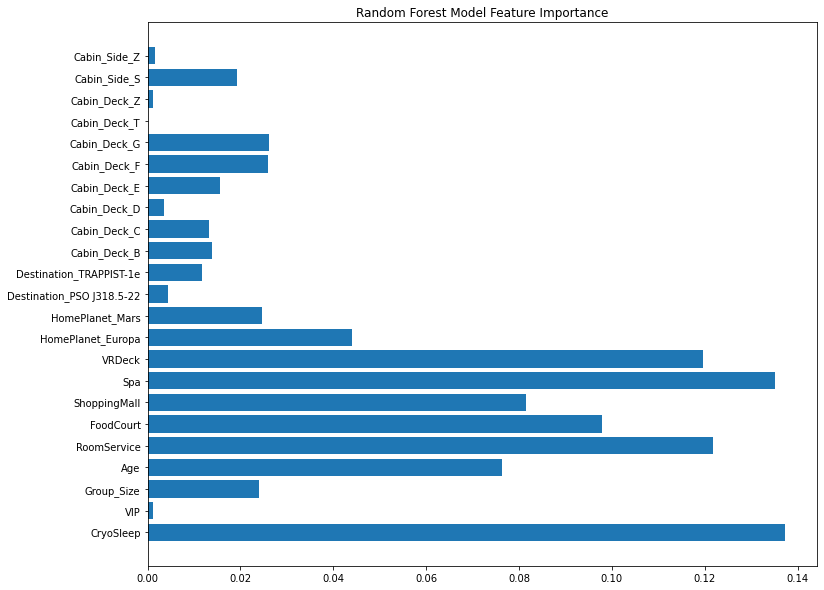

In [ ]:
plt.figure(figsize = (12,10))

plt.barh(X.columns, rf_model.feature_importances_)
plt.title('Random Forest Model Feature Importance')
plt.show()

### Analysis of Model and Feature Importance

Plotting RF feature importance confirms much of the intuition we gained during the feature analysis, with additional wrinkles: 
* Whether the passenger was in CryoSleep or not stands out as an extremely important feature for this model. While only one-third of passengers were in CryoSleep, 80% of those passengers were transported.
* Customer spend at various locations (Room Service, Spa, VR Deck, Food Court, and to a lesser extent the Shopping Mall) were also strong features, particularly the Spa. Our EDA showed major swings among customers who spent at these locations so it is not surprising they were important. 
* Other features contributed, but to lesser extent than those mentioned above. Age, Home Planet, and Group Size are notable additional features. A few Passenger Decks (F, G) and the Starboard side stick out as well. 

## Final Output for Submission

In [ ]:
output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Transported': rf_predictions})
output.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [ ]:
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
